In [1]:
import os
import warnings
from pathlib import Path

import pandas as pd
import patsy
import numpy as np
import ot
import seaborn as sns
import time

import matplotlib.pyplot as plt
import sklearn.manifold as skmf
import sklearn.decomposition as skdc
import sklearn.metrics as skmr

import condo

from combat import combat

In [2]:
this_file = os.path.realpath('__file__')
data_path = os.path.join(Path(this_file).parent.parent, 'data')
pheno = pd.read_csv(os.path.join(data_path, 'pheno25.csv'), index_col=0)
expr = pd.read_csv(os.path.join(data_path, 'expr25.csv'), index_col=0)
exprTranspose = expr.T

In [3]:
# Combat
start_time = time.time()
mod = patsy.dmatrix("~ age + cancer", pheno, return_type="dataframe")
exprTranspose_combat = combat(exprTranspose, pheno['batch'], mod, "age")
expr_combat = exprTranspose_combat.T
duration_combat = time.time() - start_time
print(f"Combat time: {duration_combat}")

# Gaussian OT
start_time = time.time()
lder = condo.LinearAdapter(
    transform_type="location-scale",
)
lder.fit(
    expr[pheno.batch == 2].values, 
    expr[pheno.batch == 5].values,
)
expr_linear = lder.transform(expr.values)
duration_linear = time.time() - start_time
print(f"Gaussian OT time: {duration_linear}")
expr_linear[np.where(pheno.batch == 5)[0],:] = expr.values[np.where(pheno.batch == 5)[0],:]

found 2 batches
found 1 numerical covariates...
	age
found 2 categorical variables:	cancer[T.Cancer], cancer[T.Normal]
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data
Combat time: 0.2125391960144043
Gaussian OT time: 10.170526266098022


In [4]:
# MMD
start_time = time.time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mmder = condo.MMDAdapter(
        transform_type="location-scale",
        optim_kwargs={"epochs": 10, "alpha": 1e-3, "beta": 0.999},
        verbose=0,
    )
    mmder.fit(
        expr[pheno.batch == 2].values, 
        expr[pheno.batch == 5].values,
    )
expr_mmd = mmder.transform(expr.values)
duration_mmd = time.time() - start_time
print(f"MMD time: {duration_mmd}")
expr_mmd[np.where(pheno.batch == 5)[0],:] = expr.values[np.where(pheno.batch == 5)[0],:]

MMD time: 382.03996086120605


In [5]:
# Condo Linear ReverseKL
start_time = time.time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cder_clinear = condo.ConDoAdapter(
        sampling="proportional",
        transform_type="location-scale",
        model_type="linear",
        divergence="reverse",
        debug=False,
        verbose=0,
    )
    cder_clinear.fit(
        expr[pheno.batch == 2].values, 
        expr[pheno.batch == 5].values,
        pheno[pheno.batch==2].result.values.reshape(-1, 1).astype(str),
        pheno[pheno.batch==5].result.values.reshape(-1, 1).astype(str),
    )
expr_clinear = cder_clinear.transform(expr.values)
duration_clinear = time.time() - start_time
print(f"ConDo Linear-ReverseKL time: {duration_clinear}")
expr_clinear[np.where(pheno.batch == 5)[0],:] = expr.values[np.where(pheno.batch == 5)[0],:]

start_time = time.time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cder_cgp = condo.ConDoAdapter(
        sampling="proportional",
        transform_type="location-scale",
        model_type="heteroscedastic-gp",
        divergence="reverse",
        debug=False,
        verbose=0,
    )
    cder_cgp.fit(
        expr[pheno.batch == 2].values, 
        expr[pheno.batch == 5].values,
        pheno[pheno.batch==2].result.values.reshape(-1, 1).astype(str),
        pheno[pheno.batch==5].result.values.reshape(-1, 1).astype(str),
    )
expr_cgp = cder_cgp.transform(expr.values)
duration_cgp = time.time() - start_time
print(f"ConDo GP-ReverseKL time: {duration_cgp}")
expr_cgp[np.where(pheno.batch == 5)[0],:] = expr.values[np.where(pheno.batch == 5)[0],:]

ConDo Linear-ReverseKL time: 221.3648281097412
fix:19973: l-bfgs failure, trying cg
-0.08594811411077062 0.07854018512178186 35.88594824064779 11.98002473177284 -73.10576846873559 1.0 -12.206802435069438
fix:20968: l-bfgs failure, trying cg
-0.14577902808853804 0.19431205181540795 146.62407846028455 24.196730559728884 -298.62547309190285 1.0 -24.685056128781543
ConDo GP-ReverseKL time: 741.8483669757843


In [6]:
start_time = time.time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cder_mmd = condo.ConDoAdapter(
        sampling="proportional",
        transform_type="location-scale",
        model_type="empirical",
        divergence="mmd",
        optim_kwargs={"epochs": 10, "alpha": 1e-4, "beta": 0.999},
        debug=False,
        verbose=0,
    )
    cder_mmd.fit(
        expr[pheno.batch == 2].values, 
        expr[pheno.batch == 5].values,
        pheno[pheno.batch==2].result.values.reshape(-1, 1).astype(str),
        pheno[pheno.batch==5].result.values.reshape(-1, 1).astype(str),
    )
expr_cmmd = cder_mmd.transform(expr.values)
duration_cmmd = time.time() - start_time
print(f"ConDo MMD: {duration_cmmd}")
expr_cmmd[np.where(pheno.batch == 5)[0],:] = expr.values[np.where(pheno.batch == 5)[0],:]

ConDo MMD: 725.1663589477539


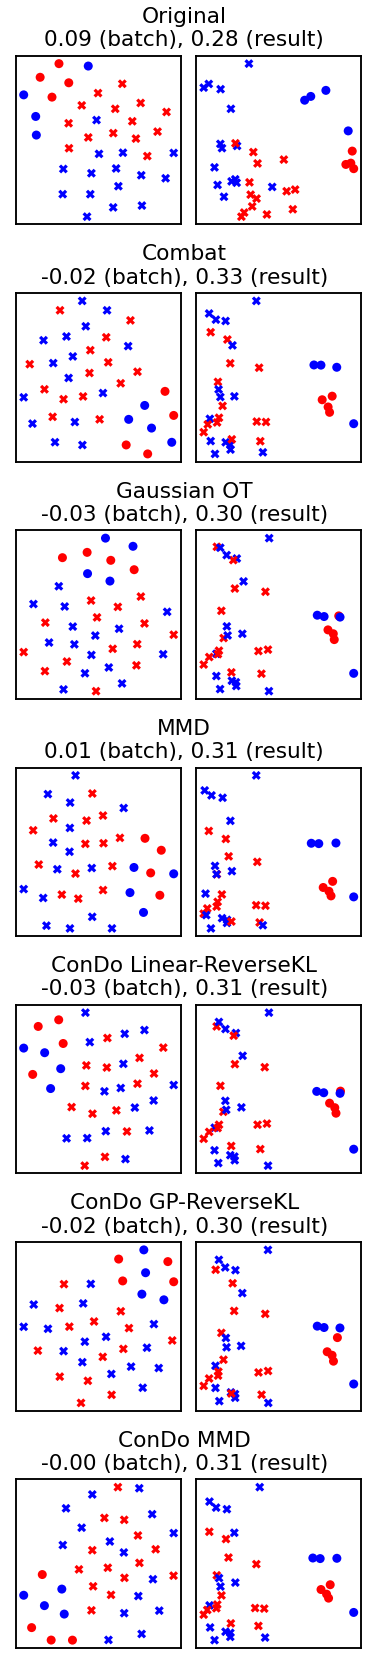

In [7]:
sns.set_context("talk")
dinfos = [
    (0, "Original", expr),
    (1, "Combat", expr_combat),
    (2, "Gaussian OT", expr_linear),
    (3, "MMD", expr_mmd),
    (4, "ConDo Linear-ReverseKL", expr_clinear),
    (5, "ConDo GP-ReverseKL", expr_cgp),
    (6, "ConDo MMD", expr_cmmd),
]
fig = plt.figure(figsize=(5, 23), constrained_layout=True)
subfigs = fig.subfigures(nrows=len(dinfos), ncols=1)

for dix, dname, dset in dinfos:
    axes = subfigs[dix].subplots(nrows=1, ncols=2)
    sil_result = skmr.silhouette_score(dset, pheno.result, metric='euclidean')
    sil_batch = skmr.silhouette_score(dset, pheno.batch, metric='euclidean')
    db_result = skmr.davies_bouldin_score(dset, pheno.result)
    db_batch = skmr.davies_bouldin_score(dset, pheno.batch)
    #dtitle = f"{dname}\n{db_batch:.2f} (batch), {db_result:.2f} (result)"
    dtitle = f"{dname}\n{sil_batch:.2f} (batch), {sil_result:.2f} (result)"
    subfigs[dix].suptitle(dtitle);  

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tsner = skmf.TSNE(n_components=2)
        tsne_embed = tsner.fit_transform(dset)
        tsne_data = pheno.copy()
        tsne_data["tsne 1"] = tsne_embed[:, 0]
        tsne_data["tsne 2"] = tsne_embed[:, 1]

    pcaer = skdc.PCA(n_components=2)
    pca_embed = pcaer.fit_transform(dset)
    pca_data = pheno.copy()
    pca_data["pc 1"] = pca_embed[:, 0]
    pca_data["pc 2"] = pca_embed[:, 1]           
    sns.scatterplot(
        data=tsne_data, ax=axes[0],
        x="tsne 1", y="tsne 2", hue="batch", style="result", 
        palette=["red", "blue"], edgecolor="none", legend=False,
    )
    if dix < 0:
        leg = "auto"
    else:
        leg = False
    sns.scatterplot(
        data=pca_data, ax=axes[1],
        x="pc 1", y="pc 2", hue="batch", style="result", 
        palette=["red", "blue"], edgecolor="none", legend=leg);
    """
    if dix == 0:
        plt.legend(
            loc="center left", bbox_to_anchor=(1.05, 0.5), ncol=2,
        );
    """
    """
    #(_, max_x) = axes[1].get_xlim();
    #(_, max_x) = axes[1].get_xlim();

    axes[1].text(
        #np.max(pca_embed[:,0])*2.0, 0.5, 
        1.2, 0.5,
        f"Silhouette\nBatch:{sil_batch:.2f}\nOutcome:{sil_result:.2f}",
        transform = axes[1].transAxes); 
    """
    axes[0].set_xticks([]);
    axes[1].set_xticks([]);
    axes[0].set_yticks([]);
    axes[1].set_yticks([]);
    axes[1].set_yticks([]);
    axes[0].set_xlabel(None);
    axes[1].set_xlabel(None);
    axes[0].set_ylabel(None);
    axes[1].set_ylabel(None);
fig.savefig("figure-bladderbatch-noconfounding.pdf", bbox_inches="tight")

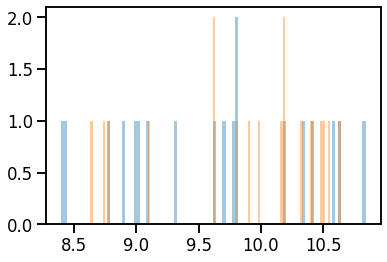

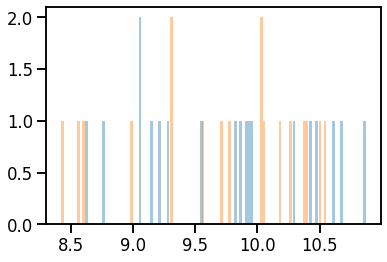

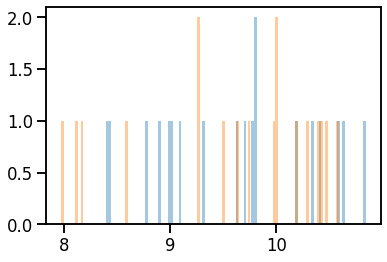

In [8]:
plt.figure();
plt.hist(expr.values[np.where(pheno.batch == 5)[0],0], 100, alpha=0.4);
plt.hist(expr.values[np.where(pheno.batch == 2)[0],0], 100, alpha=0.4);
plt.figure();
plt.hist(expr_combat.values[np.where(pheno.batch == 5)[0],0], 100, alpha=0.4);
plt.hist(expr_combat.values[np.where(pheno.batch == 2)[0],0], 100, alpha=0.4);
plt.figure();
plt.hist(expr_clinear[np.where(pheno.batch == 5)[0],0], 100, alpha=0.4);
plt.hist(expr_clinear[np.where(pheno.batch == 2)[0],0], 100, alpha=0.4);

In [9]:
print(skmr.silhouette_score(expr, pheno.result, metric='euclidean'))  # high is good
print(skmr.silhouette_score(expr, pheno.batch, metric='euclidean')) # high is bad
print(skmr.silhouette_score(expr_combat, pheno.result, metric='euclidean'))  # high is good
print(skmr.silhouette_score(expr_combat, pheno.batch, metric='euclidean')) # high is bad
print(skmr.silhouette_score(expr_linear, pheno.result, metric='euclidean'))  # high is good
print(skmr.silhouette_score(expr_linear, pheno.batch, metric='euclidean')) # high is bad
print("ConDo Linear-ReverseKL")
print(skmr.silhouette_score(expr_clinear, pheno.result, metric='euclidean'))  # high is good
print(skmr.silhouette_score(expr_clinear, pheno.batch, metric='euclidean')) # high is bad
print(skmr.silhouette_score(expr_cgp, pheno.result, metric='euclidean'))  # high is good
print(skmr.silhouette_score(expr_cgp, pheno.batch, metric='euclidean')) # high is bad

0.27981748504543436
0.08843292720229044
0.32679637936540507
-0.017795884466100198
0.3007794494751776
-0.027900412870990245
ConDo Linear-ReverseKL
0.3057765415853465
-0.027545548232061335
0.29913210243122557
-0.019285006083415313


In [10]:
pheno[pheno.batch == 5]

,sample,outcome,batch,cancer,age,result
cel,,,,,,
GSM71028.CEL,9,sTCC+CIS,5,Cancer,2,Cancer
GSM71030.CEL,11,sTCC-CIS,5,Cancer,4,Cancer
GSM71032.CEL,13,sTCC+CIS,5,Cancer,6,Cancer
GSM71034.CEL,15,sTCC+CIS,5,Cancer,8,Cancer
GSM71035.CEL,16,sTCC+CIS,5,Cancer,9,Cancer
GSM71038.CEL,19,sTCC+CIS,5,Cancer,2,Cancer
GSM71043.CEL,24,sTCC+CIS,5,Cancer,7,Cancer
GSM71046.CEL,27,sTCC+CIS,5,Cancer,10,Cancer
GSM71053.CEL,34,sTCC+CIS,5,Cancer,7,Cancer


In [11]:
pheno[pheno.batch == 2]

,sample,outcome,batch,cancer,age,result
cel,,,,,,
GSM71020.CEL,2,Normal,2,Normal,2,NotCancer
GSM71021.CEL,3,Normal,2,Normal,3,NotCancer
GSM71025.CEL,7,Normal,2,Normal,7,NotCancer
GSM71026.CEL,8,Normal,2,Normal,1,NotCancer
GSM71029.CEL,10,sTCC-CIS,2,Cancer,3,Cancer
GSM71031.CEL,12,sTCC-CIS,2,Cancer,5,Cancer
GSM71033.CEL,14,sTCC-CIS,2,Cancer,7,Cancer
GSM71036.CEL,17,sTCC-CIS,2,Cancer,10,Cancer
GSM71040.CEL,21,mTCC,2,Cancer,4,Cancer
